# Time series forecasting for Air Passenger Traffic

In [406]:
# importing relevant packages
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from scipy.stats import boxcox

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# set other options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style('darkgrid')

In [407]:
# load the data
airline = pd.read_csv('airline-passenger-traffic.csv', header=None)
airline.head()

,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [408]:
airline = pd.read_csv('airline-passenger-traffic.csv', header=None)
airline.columns = ['Months', 'Passengers']
airline.Months = pd.to_datetime(airline.Months, format='%Y-%m')
airline.set_index('Months', inplace=True)
airline.head()

,Passengers
Months,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Figure size 864x288 with 0 Axes>

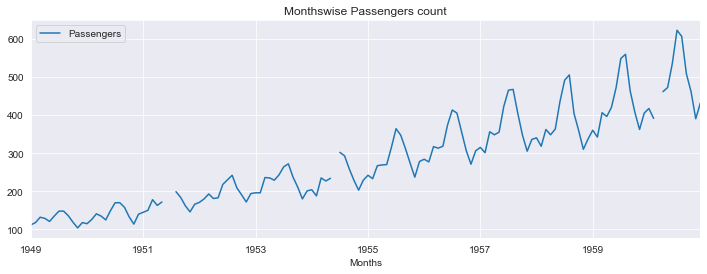

In [409]:
# PLot time series data
plt.figure(figsize=(12,4))
airline[['Passengers']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Monthswise Passengers count')
plt.show(block=False)

## Missing value treatment

In [410]:
airline.isnull().sum()

Passengers    4
dtype: int64

In [411]:
airline[np.isnan(airline['Passengers'])]

,Passengers
Months,
1951-06-01,NaN
1951-07-01,NaN
1954-06-01,NaN
1960-03-01,NaN


## Impute by Linear Interpolation
It takes average value of 1 month before and 1 month after the month where the value is missing

In [412]:
airline = airline.assign(Passengers_Linear_Interpolation = airline.Passengers.interpolate('linear'))

<Figure size 864x288 with 0 Axes>

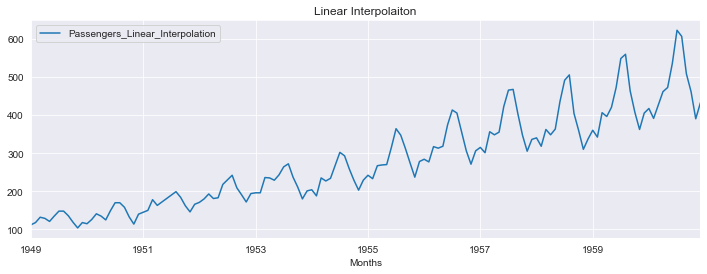

In [413]:
plt.figure(figsize=(12,4))
airline[['Passengers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Linear Interpolaiton')
plt.show(block=False)

<Figure size 864x288 with 0 Axes>

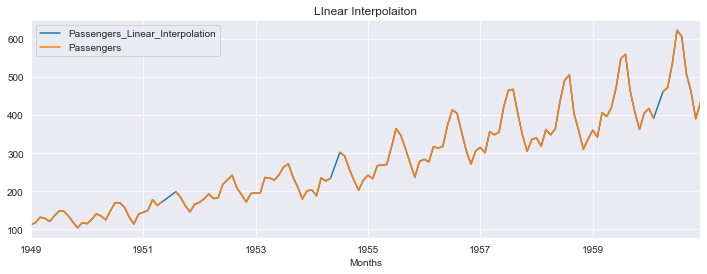

In [414]:
plt.figure(figsize=(12,4))
airline[['Passengers_Linear_Interpolation','Passengers']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('LInear Interpolaiton')
plt.show(block=False)

## Outlier detection

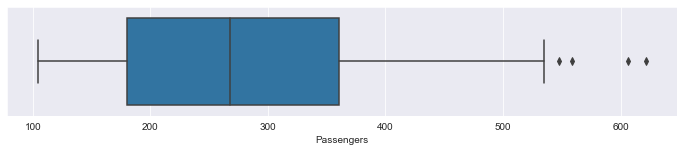

In [415]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=airline['Passengers'],whis=1)

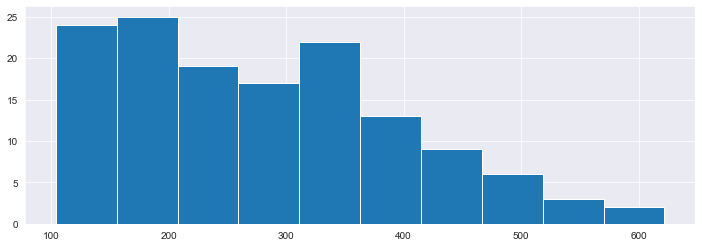

In [416]:
fig = airline.Passengers.hist(figsize = (12,4))

There are no outliers in the data set. As it can be seen thaat if, the whisker is set to 1 **(Q1 - IQR*1 & Q3 + IQR*1)** there can be seen 4 outliers, i.e above 540, but it can be noticed in the above plot that these are not outliers, infact these are seasonal pattern repeating itself.

# Model building and evaluation

## 1. Naive Method
- Forecast the values of the next 2 years based on the last observed value, i.e, last month's value

In [417]:
airline.shape

(144, 2)

In [418]:
# split into train and test set
train_len = 120 # take first 120 observations as training data
airline_train = airline[0:train_len]
airline_test = airline[train_len:] # remaining test data

print('Train {0} & Test {1}'.format(airline_train.shape, airline_test.shape))

Train (120, 2) & Test (24, 2)


In [419]:
airline_train.head()

,Passengers,Passengers_Linear_Interpolation
Months,,
1949-01-01,112.0,112.0
1949-02-01,118.0,118.0
1949-03-01,132.0,132.0
1949-04-01,129.0,129.0
1949-05-01,121.0,121.0


In [420]:
# create a new data frame same as test data so that it can be used to forecast new values and compare with the actual test data
airline_hat_naive = airline_test.copy() # deep copy

# assign last observation from train set to the unseen data
airline_hat_naive['Naive'] = airline_train['Passengers_Linear_Interpolation'][train_len-1]

airline_hat_naive.head(10)

,Passengers,Passengers_Linear_Interpolation,Naive
Months,,,
1959-01-01,360.0,360.0,337.0
1959-02-01,342.0,342.0,337.0
1959-03-01,406.0,406.0,337.0
1959-04-01,396.0,396.0,337.0
1959-05-01,420.0,420.0,337.0
1959-06-01,472.0,472.0,337.0
1959-07-01,548.0,548.0,337.0
1959-08-01,559.0,559.0,337.0
1959-09-01,463.0,463.0,337.0


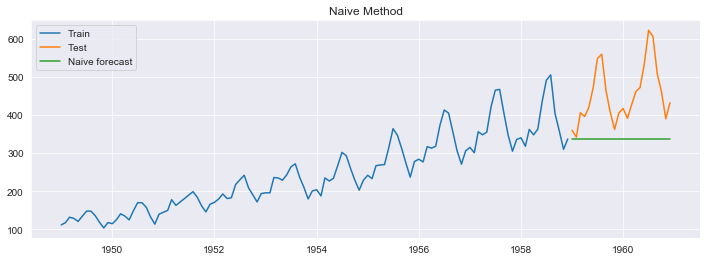

In [421]:
# plot the values
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_naive['Naive'], label='Naive forecast')
plt.title('Naive Method')
plt.legend(loc='best')
plt.show()

## 2. Simple Average Method
- Forecast's the value of the next 2 years based on the mean of the data previous to it.

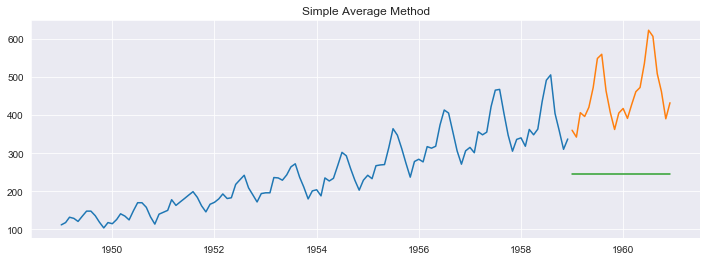

In [422]:
airline_hat_avg = airline_test.copy()

# assign the mean value of the train set
airline_hat_avg['avg_forecast'] = airline_train['Passengers_Linear_Interpolation'].mean() 

plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_avg['avg_forecast'], label='Simple Average Forecast')
plt.title('Simple Average Method')
plt.show()

The green line shows the average forecast based on the blue data(train set). it can be observed that the forecasted values are way below the actual data. This is because in the earlier years the values were very less leading to the overall average to be way below the actual values. Here, this method is underforecasting.

`It does not capture the seasonality of the data. `

## Calculate RMSE and MAPE for Naive method

In [423]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_naive['Naive'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_naive['Naive'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

results = pd.DataFrame({'Method': ['Naive Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51


## Calculate RMSE and MAPE for Simple Average method

In [424]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_avg['avg_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Simple Avergae Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69


`Naive method performs better`

## 3. Simple Moving Average Method

In [425]:
airline_hat_sma = airline.copy()
sma_window = 12
# the below will handle the moving average part using the 'rolling' method 
airline_hat_sma['sma'] = airline['Passengers_Linear_Interpolation'].rolling(sma_window).mean()

# since the test data does not have prior data, the forecast will happen based on the last data point
# The last data point is already calculated with 12 months data. it's the mean  of the past 12 months. 
# the same value can be taken for future predictions on the test set
airline_hat_sma['sma'][train_len:] = airline_hat_sma['sma'][train_len-1]

In [426]:
airline_hat_sma.tail(26)

,Passengers,Passengers_Linear_Interpolation,sma
Months,,,
1958-11-01,310.0,310.0,380.916667
1958-12-01,337.0,337.0,381.000000
1959-01-01,360.0,360.0,381.000000
1959-02-01,342.0,342.0,381.000000
1959-03-01,406.0,406.0,381.000000
1959-04-01,396.0,396.0,381.000000
1959-05-01,420.0,420.0,381.000000
1959-06-01,472.0,472.0,381.000000
1959-07-01,548.0,548.0,381.000000


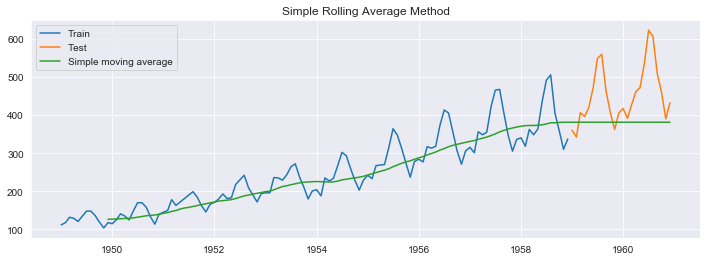

In [427]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_sma['sma'], label='Simple moving average')
plt.legend(loc='best')
plt.title('Simple Rolling Average Method')
plt.show()

1. Simple moving average does better than simple average method
2. It captures the trend
3. It does not capture the seasonal affects during an year, since the next months data is calculated by considering the mean of the past 12 months. that's why it's flattened.

In [428]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_sma['sma'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_sma['sma'][train_len:])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Simple Moving Average Method (12 months)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33


In [429]:
airline_hat_sma = airline.copy()
sma_window = 6
# the below will handle the moving average part using the 'rolling' method 
airline_hat_sma['sma'] = airline['Passengers_Linear_Interpolation'].rolling(sma_window).mean()

# since the test data does not have prior data, the forecast will happen based on the last data point
# The last data point is already calculated with 12 months data. it's the mean  of the past 12 months. 
# the same value can be taken for future predictions on the test set
airline_hat_sma['sma'][train_len:] = airline_hat_sma['sma'][train_len-1]

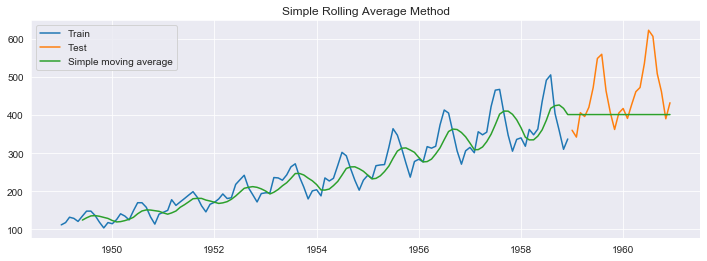

In [430]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_sma['sma'], label='Simple moving average')
plt.legend(loc='best')
plt.title('Simple Rolling Average Method')
plt.show()

In [431]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_sma['sma'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_sma['sma'][train_len:])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Simple Moving Average Method (6 Months)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64


In [432]:
airline_hat_sma = airline.copy()
sma_window = 3
# the below will handle the moving average part using the 'rolling' method 
airline_hat_sma['sma'] = airline['Passengers_Linear_Interpolation'].rolling(sma_window).mean()

# since the test data does not have prior data, the forecast will happen based on the last data point
# The last data point is already calculated with 12 months data. it's the mean  of the past 12 months. 
# the same value can be taken for future predictions on the test set
airline_hat_sma['sma'][train_len:] = airline_hat_sma['sma'][train_len-1]

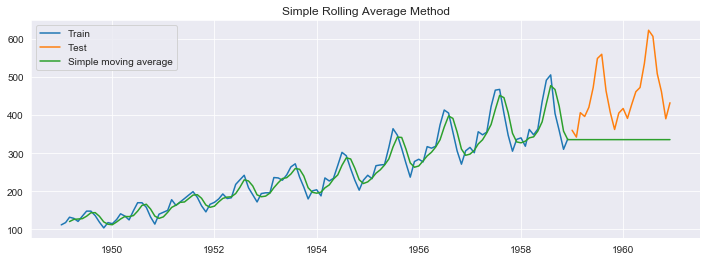

In [433]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_sma['sma'], label='Simple moving average')
plt.legend(loc='best')
plt.title('Simple Rolling Average Method')
plt.show()

In [434]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_sma['sma'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_sma['sma'][train_len:])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Simple Moving Average Method (3 months)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91


## 4. Simple Exponential Smoothing

In [435]:
ses = SimpleExpSmoothing(airline_train['Passengers_Linear_Interpolation'])
airline_hat_ses = airline_test.copy()
# optimazed is false, since an optimization parameter 'smoothing_level' is explicitly being provided
model = ses.fit(optimized=False, smoothing_level=0.2)
airline_hat_ses['ses_forecast'] = model.forecast(24) # since need to forecast for the next 2 years, i.e., 24 months
model.params

{'smoothing_level': 0.2,
 'smoothing_slope': None,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 112.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

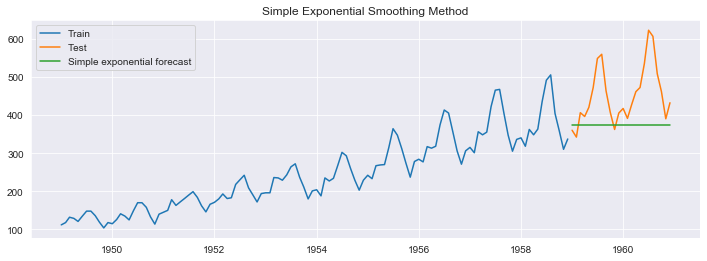

In [436]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_ses['ses_forecast'], label='Simple exponential forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [437]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_ses['ses_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Simple Exponential Smoothing Method (alpha = 0.2)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65


In [438]:
ses = SimpleExpSmoothing(airline_train['Passengers_Linear_Interpolation'])
model = ses.fit(optimized=False, smoothing_level=0.3)
airline_hat_ses['ses_forecast'] = model.forecast(24)
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_ses['ses_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Simple Exponential Smoothing Method (alpha = 0.3)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19


In [439]:
ses = SimpleExpSmoothing(airline_train['Passengers_Linear_Interpolation'])
model = ses.fit()
airline_hat_ses['ses_forecast'] = model.forecast(24)

rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_ses['ses_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Simple Exponential Smoothing Method (optimized=True)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51


In [440]:
model.summary()

Dep. Variable:,endog,No. Observations:,120
Model:,SimpleExpSmoothing,SSE,97885.000
Optimized:,True,AIC,808.487
Trend:,None,BIC,814.062
Seasonal:,None,AICC,808.835
Seasonal Periods:,None,Date:,"Mon, 17 Aug 2020"
Box-Cox:,False,Time:,02:25:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,112.00000,l.0,True


## 5. Holt's Exponential smoothing with Trend

In [441]:
# for linear trend we use 'Additive' decomposition and for more exponential trend we use 'Multiplicative' trend
# seasonal_periods = 12, since the data is in a monthly fashion. Even though ExponentialSmoothing does not capture seasonal
# effects, we wont' be actually using this parameter; it's just mentioned here. 
# seasonl=False, since no seasonality is being captured here

In [442]:
exp = ExponentialSmoothing(np.asarray(airline_train['Passengers_Linear_Interpolation']), seasonal_periods=12,
                           trend='additive', seasonal=False)

airline_hat_exp = airline_test.copy()
# the reason to select a lower number for 'smoothing slope' is that we don't want these seasonal fluctuations to drive the 
# slope up and down too much. So we want to flatten out the slope over a longer time period because the slope is more due to
# the year-on-year increase and not due to month-on-month variation, whcih goes up and down.
model_exp = exp.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model.params)
airline_hat_exp['exp_forecast'] = model_exp.forecast(24)

{'smoothing_level': 1.0, 'smoothing_slope': nan, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Text(0.5, 1.0, "Holt's Exponential smoothing method")

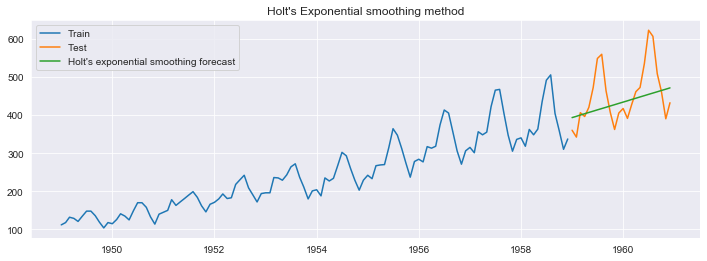

In [443]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_exp['exp_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential smoothing method')

In [444]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_exp['exp_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_exp['exp_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Holt\'s Exponential Smoothing Method (b=0.01)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94


In [445]:
exp = ExponentialSmoothing(np.asarray(airline_train['Passengers_Linear_Interpolation']), seasonal_periods=12,
                           trend='additive', seasonal=False)

airline_hat_exp = airline_test.copy()
model_exp = exp.fit(smoothing_level=0.2, smoothing_slope=0.1, optimized=False)
print(model.params)
airline_hat_exp['exp_forecast'] = model_exp.forecast(24)

rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_exp['exp_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_exp['exp_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Holt\'s Exponential Smoothing Method (b=0.1)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

{'smoothing_level': 1.0, 'smoothing_slope': nan, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


In [446]:
exp = ExponentialSmoothing(np.asarray(airline_train['Passengers_Linear_Interpolation']), seasonal_periods=12,
                           trend='additive', seasonal=False)

airline_hat_exp = airline_test.copy()
model_exp = exp.fit(smoothing_level=0.2, smoothing_slope=0.001, optimized=False)
print(model.params)
airline_hat_exp['exp_forecast'] = model_exp.forecast(24)

rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_exp['exp_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_exp['exp_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Holt\'s Exponential Smoothing Method (b=0.001)'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

{'smoothing_level': 1.0, 'smoothing_slope': nan, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


`More the value of` $\beta$`, more it caputers the trend of the recent or shorter period and vice versa`

## 6. Holt-winter's additive smoothing method

In [447]:
hwa = ExponentialSmoothing(np.asarray(airline_train['Passengers_Linear_Interpolation']), seasonal_periods=12, trend='additive',
                          seasonal='additive')
model_hwa = hwa.fit(optimized=True)
print(model_hwa.params)

airline_hat_hwa = airline_test.copy()
airline_hat_hwa['hwa_forecast'] = model_hwa.forecast(24)

{'smoothing_level': 0.2631578931410015, 'smoothing_slope': 0.05162966025765116, 'smoothing_seasonal': 0.7368421036673173, 'damping_slope': nan, 'initial_level': 211.55099866332293, 'initial_slope': 1.7391915752033313, 'initial_seasons': array([-100.18118437,  -94.2046477 ,  -80.29175565,  -83.41758365,
        -91.45908078,  -77.4509434 ,  -64.48324357,  -64.57340564,
        -76.66644176,  -93.73584142, -108.67610965,  -94.50947707]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Text(0.5, 1.0, "Holt Winter's Exponential Additive smoothing method")

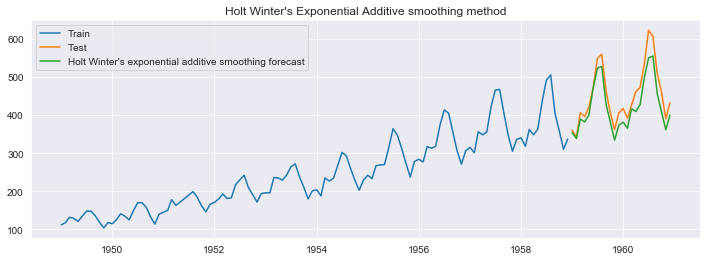

In [448]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_hwa['hwa_forecast'], label='Holt Winter\'s exponential additive smoothing forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Exponential Additive smoothing method')

In [449]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_hwa['hwa_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Holt Winter\'s Exponential Additive smoothing method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


## 7. Holt-winter's multiplicative smoothning method

In [450]:
hwa = ExponentialSmoothing(np.asarray(airline_train['Passengers_Linear_Interpolation']), seasonal_periods=12, trend='additive',
                          seasonal='multiplicative')
model_hwa = hwa.fit(optimized=True)
print(model_hwa.params)

airline_hat_hwa = airline_test.copy()
airline_hat_hwa['hwa_forecast'] = model_hwa.forecast(24)

{'smoothing_level': 0.38297792357726124, 'smoothing_slope': 0.035502695358352605, 'smoothing_seasonal': 0.6170220681283785, 'damping_slope': nan, 'initial_level': 212.3983506469908, 'initial_slope': 1.095376632423797, 'initial_seasons': array([0.51702061, 0.5454338 , 0.60215765, 0.56916567, 0.51982655,
       0.57235007, 0.62776238, 0.62555286, 0.57005795, 0.49511555,
       0.43967716, 0.51387414]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Text(0.5, 1.0, "Holt Winter's Exponential Additive smoothing method")

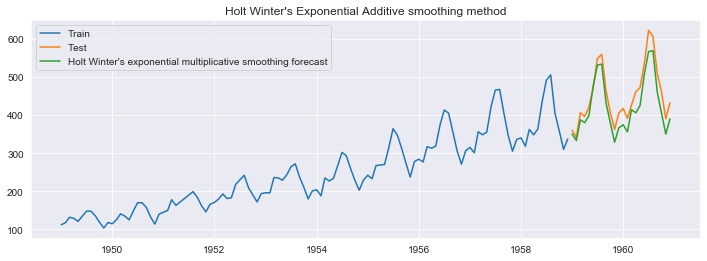

In [451]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(airline_hat_hwa['hwa_forecast'], label='Holt Winter\'s exponential multiplicative smoothing forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Exponential Additive smoothing method')

In [452]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], airline_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(
    airline_test['Passengers_Linear_Interpolation'] - airline_hat_hwa['hwa_forecast'])
                        / airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Holt Winter\'s Exponential Multiplicative smoothing method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


In [453]:
results.sort_values(by='MAPE')

,Method,MAPE,RMSE
0,Holt Winter's Exponential Additive smoothing method,6.53,35.10
0,Holt Winter's Exponential Multiplicative smoothing method,6.92,34.87
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Holt's Exponential Smoothing Method (b=0.001),13.26,70.97
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Naive Method,23.63,137.51


### Holt Winter's Exponential Additive Smoothing method gives the best result so far. 
#### Now, let's try out the Auto Regressive models., i.e., forecast future observations using a linear combination of past observations of the same variable

## Checking the assumptions of autoregressive models:

1. #### Stationarity
    - Mean should be constant over time
    - Variance should be constant
    - Covariance should be constant
    
    
2. #### Autocorrelation

    - Autocorrelation function (ACF)
    - Partial autocorrelation function (PACF)

## Time Series Stationary Test

---
    
### Augmented Dickey-Fuller (ADF) Test

- Null Hypothesis ($H_0$): The series is not stationary
    - $p−value > 0.05$ 
    
    
- Alternate Hypothesis ($H_1$): The series is stationary
    - $p−value ≤ 0.05$      
   
    
---    

In [454]:
adf_test = adfuller(airline['Passengers_Linear_Interpolation'])
adf_test

(0.894608794082385,
 0.9930195647605924,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 993.7736365973918)

In [455]:
print('ADF Statistics: %f' % adf_test[0])
print('Critical value @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistics: 0.894609
Critical value @ 0.05: -2.88
p-value: 0.993020


p-value here is more than 0.05, which means that the null hypothesis ($H_0$) cannot be rejected.<br>
Also, ADF statistic is greater than the critical value, the null hypothesis cannot be rejected. <br>
Here, the time series is **not stationary**

---

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

- Null Hypothesis ($H_0$): The series is stationary
    - $p−value > 0.05$ 
    
    
- Alternate Hypothesis ($H_1$): The series is not stationary
    - $p−value ≤ 0.05$
    
---    

In [456]:
kpss_test = kpss(airline['Passengers_Linear_Interpolation'])
kpss_test

(1.0520501504573108,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [457]:
print('KPSS Statistics: %f' % kpss_test[0])
print('Critical value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistics: 1.052050
Critical value @ 0.05: 0.46
p-value: 0.010000


p-value is less than 0.05, which means that the null hypothesis ($H_0$) can  be rejected.<br>
Kpss statistic is greater than critical value, the null hypothesis can be rejected. <br>
Hers, again the time series is **not stationary**.

Since the series is not stationary, let's convert it to a stationary series.

Will use two tools to convert this series:
1. #### Differencing
    - To remove the trend (to make the mean constant)
2. #### Transformation
    - To make the variance constan

## Box Cox transformation


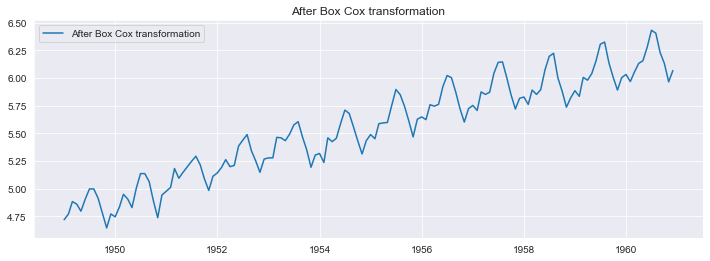

In [458]:
airline_boxcox = pd.Series(boxcox(airline['Passengers_Linear_Interpolation'], lmbda=0), index=airline.index)
plt.figure(figsize=(12,4))
plt.plot(airline_boxcox, label='After Box Cox transformation')
plt.legend(loc='best')
plt.title('After Box Cox transformation')
plt.show()

## Differencing

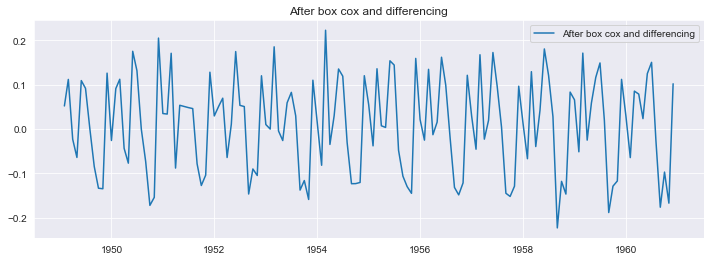

In [459]:
airline_diff = pd.Series(airline_boxcox - airline_boxcox.shift(),index=airline.index)
## since shift() takes out the difference between two values, 
# and the first value will become NaN bacause there is no value before the first one.
# y1-y0 = NaN
airline_diff.dropna(inplace=True) 
# airline_diff.reset_index(drop='index', inplace=True)

plt.figure(figsize=(12,4))
plt.plot(airline_diff, label='After box cox and differencing')
plt.legend(loc='best')
plt.title('After box cox and differencing')
plt.show()

The meanis now centered around zero. The variance also seems to be constant, but let's test them statistically.

In [460]:
# ADF test
adf_test = adfuller(airline_diff)
adf_test

(-3.2901138184594108,
 0.015326212237944533,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -438.57103816956396)

In [461]:
print('ADF Statistics: %f' % adf_test[0])
print('Critical Value @0.05: %.2f' % adf_test[4]['5%'])
print('p-value %f' % adf_test[1])

ADF Statistics: -3.290114
Critical Value @0.05: -2.88
p-value 0.015326


p-value is less than 0.05, hence $H_0$ can be rejected. The series is **now stationary**.

In [462]:
# kpss test
kpss_test = kpss(airline_diff)
kpss_test

(0.1018708149351519,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [463]:
print('KPSS Statistics: %f' % kpss_test[0])
print('Critical value @0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistics: 0.101871
Critical value @0.05: 0.46
p-value: 0.100000


p-value is greater than 0.05, hence $H_0$ cannot be rejected. the series is **stationary**.

## Autocorrelation function (ACF)

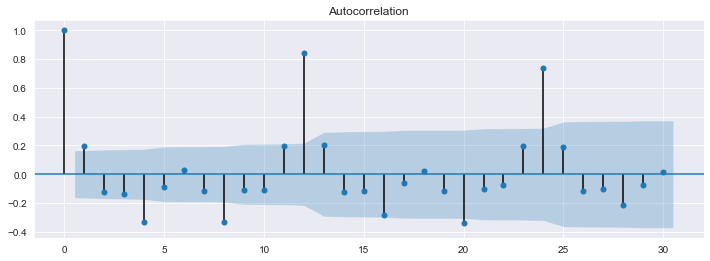

In [464]:
plt.figure(figsize=(12,4))
plot_acf(airline_diff, ax=plt.gca(), lags=30)
plt.show()

anything that lies beyond the <font color='blue'>blue</font> band has significant correlation with the original values

### Determine value of 'q'

Select q as the highest lag beyond which autocorrelation lies down:

Here, lag 12 and lag 24, the autocorrelation is above significance level. Select **q=12** as it is the highest lag beyond which autocorrelation lies down.

## Partial autocorrelation function (PACF)

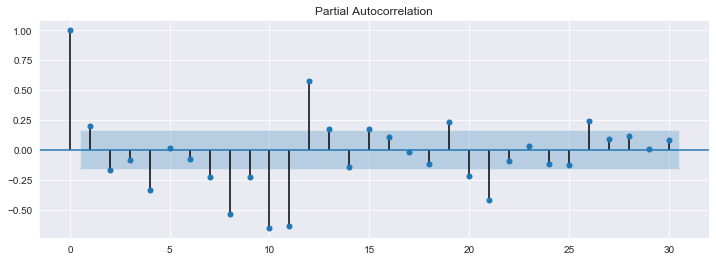

In [465]:
plt.figure(figsize=(12,4))
plot_pacf(airline_diff, ax=plt.gca(), lags=30)
plt.show()

### Determine the value of 'p':
Here, the lag value of 8, 10, 11 and 12 has a significant level of confidence. i.e., significant level of influence on future observation.
Hence, the value of 'p' will be set to **10** since that is the highest lag where partial autocorrelation is significantly high.

## Split in train and test

In [466]:
train_len = 120
train_airline_boxcox = airline_boxcox[:train_len]
test_airline_boxcox = airline_boxcox[train_len:]
train_airline_boxcox_diff = airline_diff[:train_len-1] # here len-1 is taken since we deleted the first row after differencing
test_airline_boxcox_diff = airline_diff[train_len-1:]

print('train_boxcox {0} and test_boxcox {1}'.format(train_airline_boxcox.shape,test_airline_boxcox.shape))
print('train_boxcox_diff {0} and test_boxcox_diff {1}'.format(train_airline_boxcox_diff.shape,test_airline_boxcox_diff.shape))

train_boxcox (120,) and test_boxcox (24,)
train_boxcox_diff (119,) and test_boxcox_diff (24,)


## 8. The Simple Auto Regressive Model (AR)

In [467]:
arima = ARIMA(train_airline_boxcox_diff, order=(10,0,0)) # order=(p,d,q) p = 10, since it's a simple AR model
arima_model = arima.fit(verbose=1)
arima_model.params

const       0.010124
ar.L1.y    -0.203216
ar.L2.y    -0.558652
ar.L3.y    -0.234402
ar.L4.y    -0.666149
ar.L5.y    -0.307165
ar.L6.y    -0.478985
ar.L7.y    -0.251229
ar.L8.y    -0.680785
ar.L9.y    -0.276617
ar.L10.y   -0.591435
dtype: float64

In [468]:
y_hat_ar = airline_diff.copy()
# for predicting in AR, we need to pass the range as min and max index, since we want to forecast for the entire data set
y_hat_ar['ar_forecast_boxcox_diff'] = arima_model.predict(airline_diff.index.min(), airline_diff.index.max())
# recover from differencing by using cumsum(), sort of like integration, since it was differentiated before
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
# add the first row which was deleted earlier
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(airline_boxcox[0])
# recover from the boxcox transformation. since lambda was taken a 0, which was log(y), taking exponential of it will help
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

## Plot train, test and prediction

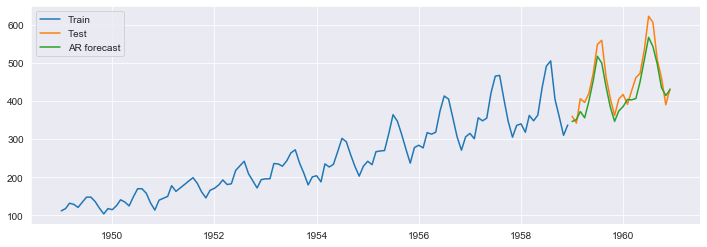

In [469]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][airline_test.index.min():], label='AR forecast')
plt.legend(loc='best')
plt.show()

In [470]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], y_hat_ar['ar_forecast'][airline_test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(airline_test['Passengers_Linear_Interpolation'] - y_hat_ar['ar_forecast'][airline_test.index.min():])
               /airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Auto Regressive (AR) Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


## 9. Moving Average Model (MA)

In [471]:
arima = ARIMA(train_airline_boxcox_diff, order=(0,0,4)) # order=(p,d,q) q = 4, since it's a simple MA model
arima_model = arima.fit()
arima_model.params

const      0.010608
ma.L1.y    0.001183
ma.L2.y   -0.326361
ma.L3.y   -0.228636
ma.L4.y   -0.446185
dtype: float64

In [472]:
y_hat_ma = airline_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = arima_model.predict(airline_diff.index.min(), airline_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(airline_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

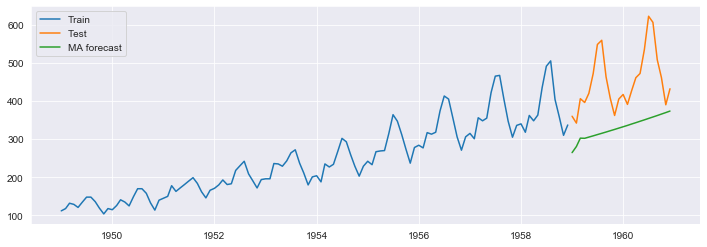

In [473]:
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][airline_test.index.min():], label='MA forecast')
plt.legend(loc='best')
plt.show()

In [474]:
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], y_hat_ma['ma_forecast'][airline_test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(airline_test['Passengers_Linear_Interpolation'] - y_hat_ma['ma_forecast'][airline_test.index.min():])
               /airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Moving Average (MA) Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


## 10. Auto Regressive Moving Average (ARMA)

In [475]:
model = ARIMA(train_airline_boxcox_diff, order=(10,0,4)) #p,d,q
model_fit = model.fit()
model_fit.params

const       0.009836
ar.L1.y     0.065554
ar.L2.y    -0.967108
ar.L3.y    -0.007120
ar.L4.y    -0.873691
ar.L5.y    -0.104559
ar.L6.y    -0.732736
ar.L7.y    -0.155670
ar.L8.y    -0.774055
ar.L9.y    -0.108753
ar.L10.y   -0.818137
ma.L1.y    -0.335131
ma.L2.y     0.941357
ma.L3.y    -0.289306
ma.L4.y     0.545155
dtype: float64

In [476]:
# recover time series data
y_hat_arma = airline_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(airline_diff.index.min(), 
                                                              airline_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(airline_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

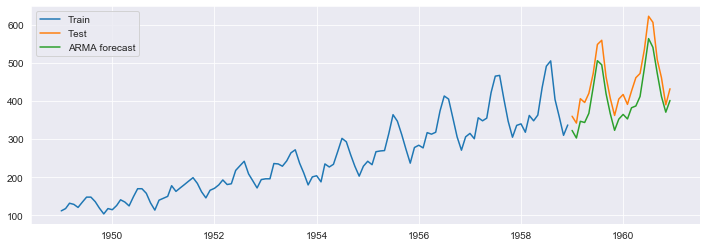

In [477]:
# plot series
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][airline_test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.show()

In [478]:
# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], y_hat_arma['arma_forecast'][airline_test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(airline_test['Passengers_Linear_Interpolation']- y_hat_arma['arma_forecast'][airline_test.index.min():])/
                       airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Auto Regressive Moving Average (ARMA) Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,temp_results])
results

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


## 11.  Auto Regressive Integrated Moving Average (ARIMA)

In [479]:
# only the boxcoxed train df is being used. the parameter 'I' of ARIMA will take care of the differencing
model = ARIMA(train_airline_boxcox, order=(10,1,4)) #p,d,q
model_fit= model.fit()
model_fit.params

const         0.009836
ar.L1.D.y     0.065554
ar.L2.D.y    -0.967108
ar.L3.D.y    -0.007120
ar.L4.D.y    -0.873691
ar.L5.D.y    -0.104559
ar.L6.D.y    -0.732736
ar.L7.D.y    -0.155670
ar.L8.D.y    -0.774055
ar.L9.D.y    -0.108753
ar.L10.D.y   -0.818137
ma.L1.D.y    -0.335131
ma.L2.D.y     0.941357
ma.L3.D.y    -0.289306
ma.L4.D.y     0.545155
dtype: float64

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


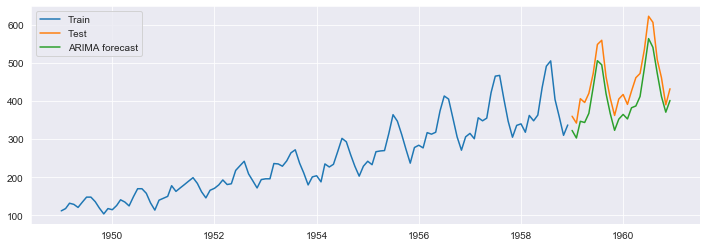

In [480]:
# recover time series data

# notice that the differenced df is used here, since it has one data less
# also, since the model will actually give a differenced series, it's better to use diff df to copy. 
y_hat_arima = airline_diff.copy() 
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(airline_diff.index.min(), 
                                                              airline_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(airline_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

# plot series
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][airline_test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')

# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], y_hat_arima['arima_forecast'][airline_test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(airline_test['Passengers_Linear_Interpolation']- y_hat_arima['arima_forecast'][airline_test.index.min():])/
                       airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Auto Regressive Integrated Moving Average (ARIMA) Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,temp_results])
results

## 12. Seasonal Auto Regressive Interated Moving Average (SARIMA) Model

In [481]:
model = SARIMAX(train_airline_boxcox, order=(10,1,4), seasonal_order=(1,1,1,12))
model_fit = model.fit()
model_fit.params

ar.L1      -0.121245
ar.L2      -0.043962
ar.L3      -0.092032
ar.L4      -0.081003
ar.L5       0.108351
ar.L6       0.032907
ar.L7      -0.124118
ar.L8       0.043294
ar.L9       0.122385
ar.L10     -0.029261
ma.L1      -0.168757
ma.L2       0.001327
ma.L3      -0.044630
ma.L4      -0.099724
ar.S.L12   -0.017589
ma.S.L12   -0.515623
sigma2      0.001312
dtype: float64

In [482]:
# recover the original series
y_hat_sarima = airline_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(airline_diff.index.min(), airline_diff.index.max())
# notice here that it's not required to return from difference to boxcox tranformation. Here the SARIMAX method handles it
# it first differentiates and then integrates the series back. so, only removing the boxcox transformation is required
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

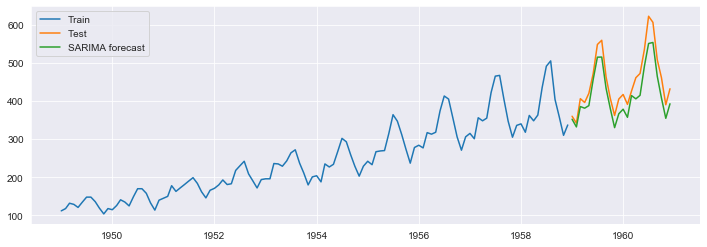

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


In [483]:
# plot series
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][airline_test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.show()

# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], y_hat_sarima['sarima_forecast'][airline_test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(airline_test['Passengers_Linear_Interpolation']- y_hat_sarima['sarima_forecast'][airline_test.index.min():])/
                       airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Seasonal Auto Regressive Integrated Moving Average (SARIMA) Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,temp_results])
results

## 13. Seasonal Auto Regressive Integrated Moving Average with Exogenous variables (SARIMAX)

Let's take an additional variable called as 'promotion'. This gives information whether there was a promotion for flight fares in a particular month or not

In [484]:
promo = pd.read_csv('promotion.csv', header=None)
promo.columns = ['Months', 'Promotion']
promo.Months = pd.to_datetime(promo.Months, format='%Y-%m')
promo.set_index('Months', inplace=True)
promo.head()

,Promotion
Months,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0


In [485]:
promo.shape

(144, 1)

In [486]:
train_len = 120
promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [487]:
model = SARIMAX(train_airline_boxcox, order=(10,1,4), seasonal_order=(1,1,1,12), exog=promo_train)
model_fit = model.fit()
model_fit.params

Promotion    0.033677
ar.L1       -0.122330
ar.L2       -0.043186
ar.L3       -0.102800
ar.L4       -0.085131
ar.L5        0.123551
ar.L6        0.048678
ar.L7       -0.109192
ar.L8        0.069087
ar.L9        0.137900
ar.L10      -0.033380
ma.L1       -0.141182
ma.L2       -0.028252
ma.L3       -0.088803
ma.L4       -0.061477
ar.S.L12    -0.043248
ma.S.L12    -0.509529
sigma2       0.001245
dtype: float64

In [488]:
# recover series
y_hat_sarimax = airline_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(airline_diff.index.min(),
                                                             airline_diff.index.max(), exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

,Method,MAPE,RMSE
0,Naive Method,23.63,137.51
0,Simple Avergae Method,44.28,219.69
0,Simple Moving Average Method (12 months),15.54,103.33
0,Simple Moving Average Method (6 Months),12.97,90.64
0,Simple Moving Average Method (3 months),24.01,138.91
0,Simple Exponential Smoothing Method (alpha = 0.2),16.49,107.65
0,Simple Exponential Smoothing Method (alpha = 0.3),17.87,114.19
0,Simple Exponential Smoothing Method (optimized=True),23.63,137.51
0,Holt's Exponential Smoothing Method (b=0.01),11.11,71.94
0,Holt's Exponential Smoothing Method (b=0.1),13.98,96.29


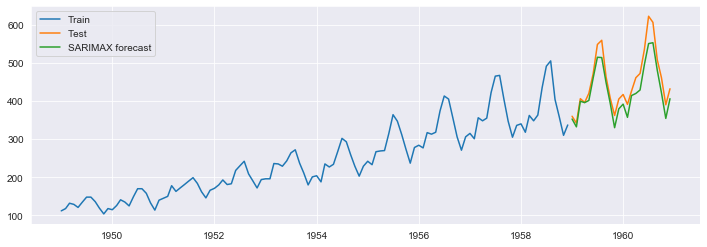

In [489]:
# plot series
plt.figure(figsize=(12,4))
plt.plot(airline_train['Passengers_Linear_Interpolation'], label='Train')
plt.plot(airline_test['Passengers_Linear_Interpolation'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][airline_test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')

# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(airline_test['Passengers_Linear_Interpolation'], y_hat_sarimax['sarimax_forecast'][airline_test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(airline_test['Passengers_Linear_Interpolation']- y_hat_sarimax['sarimax_forecast'][airline_test.index.min():])/
                       airline_test['Passengers_Linear_Interpolation'])*100,2)

temp_results = pd.DataFrame({'Method': ['Seasonal Auto Regressive Integrated Moving Average with Exogenous variables (SARIMAX) Method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,temp_results])
results

# Top 5 models

In [490]:
results.sort_values(by='MAPE')[:5]

,Method,MAPE,RMSE
0,Seasonal Auto Regressive Integrated Moving Average with Exogenous variables (SARIMAX) Method,5.91,32.44
0,Auto Regressive (AR) Method,6.05,32.32
0,Holt Winter's Exponential Additive smoothing method,6.53,35.10
0,Holt Winter's Exponential Multiplicative smoothing method,6.92,34.87
0,Seasonal Auto Regressive Integrated Moving Average (SARIMA) Method,7.57,38.55


### SARIMAX model gives the best results. It has the least MAPE. This indicates that the additional promotion variable is significant in forecasting the number of passengers in the next 12 months.